In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from nltk.metrics.agreement import AnnotationTask
from sklearn.metrics import cohen_kappa_score as kappa
from sklearn.metrics import accuracy_score as accuracy
from scipy.stats import pearsonr as pearson
from scipy.stats import spearmanr as spearman
from math import isnan
from collections import Counter
import random
pd.set_option('max_colwidth', -1)                # shows entire contents of pandas row

In [2]:
attributes = {"part", "kind", "abs"}
attr_map = {"part": "Is.Particular", "kind": "Is.Kind", "abs": "Is.Abstract"}
attr_conf = {"part": "Part.Confidence", "kind": "Kind.Confidence", "abs": "Abs.Confidence"}

# attributes = {"part", "dyn", "hyp"}
# attr_map = {"part": "Is.Particular", "dyn": "Is.Dynamic", "hyp": "Is.Hypothetical"}
# attr_conf = {"part": "Part.Confidence", "dyn": "Dyn.Confidence", "hyp": "Hyp.Confidence"}

data_file = "../../../data/arg_raw_data.tsv"
data = pd.read_csv(data_file, sep="\t")

# data_file = "../../../data/pred_raw_data.tsv"
# data = pd.read_csv(data_file, sep="\t")

data['Unique.ID'] = data.apply(lambda x: x['Split'] + " sent_" + str(x['Sentence.ID']) +\
                               "_" + str(x["Span"]), axis=1)
data_test = data[data['Split'] == "test"]
data_dev = data[data['Split'] == "dev"]
data = data[data['Split'] == "train"]
print(len(data), len(data_test), len(data_dev))

30035 10500 10833


## Count plots and heat maps of annotations

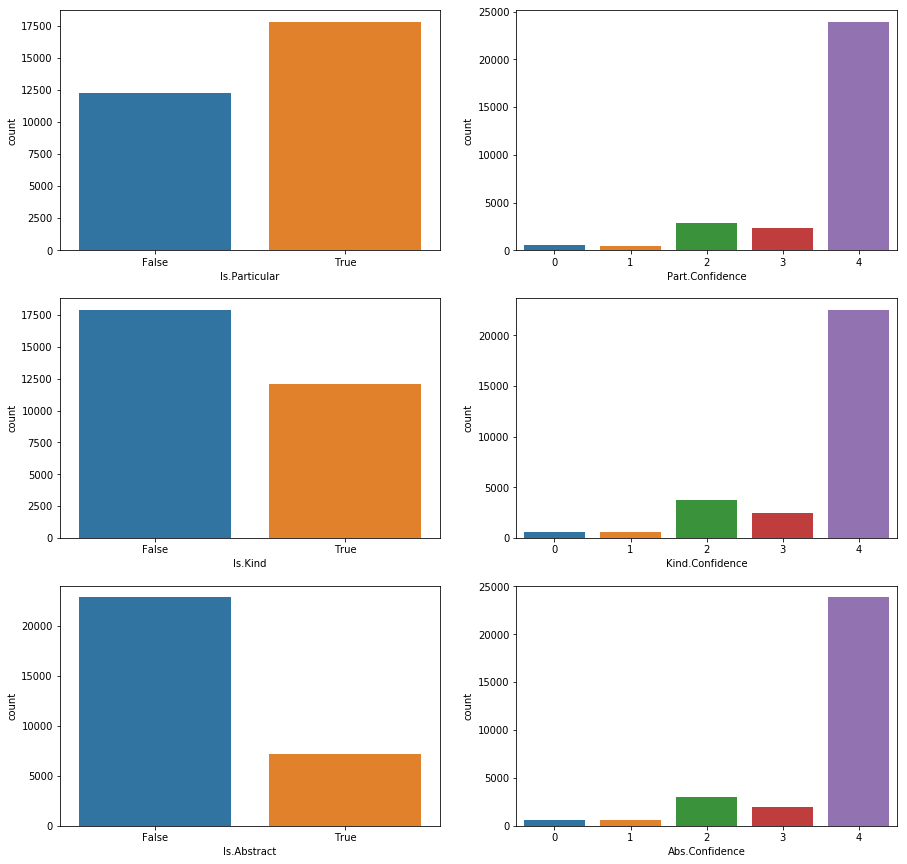

In [3]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 15))
sns.countplot(x='Is.Particular', data=data, ax=axs[0][0])
sns.countplot(x='Is.Kind', data=data, ax=axs[1][0])
sns.countplot(x='Is.Abstract', data=data, ax=axs[2][0])

sns.countplot(x='Part.Confidence', data=data, ax=axs[0][1])
sns.countplot(x='Kind.Confidence', data=data, ax=axs[1][1])
sns.countplot(x='Abs.Confidence', data=data, ax=axs[2][1])

plt.show()

Kind.Confidence                      0    1    2    3      4
Is.Particular Is.Kind Is.Abstract                           
False         False   False        385  27   38   15   213  
                      True         29   93   595  268  2963 
              True    False        23   93   809  739  4859 
                      True         11   49   268  177  594  
True          False   False        41   157  997  771  10142
                      True         9    70   211  160  736  
              True    False        22   107  677  273  2492 
                      True         61   39   186  96   540  
                                   Annotator.ID
Is.Particular Is.Kind Is.Abstract              
False         False   False        678         
                      True         3948        
              True    False        6523        
                      True         1099        
True          False   False        12108       
                      True         1186        
      

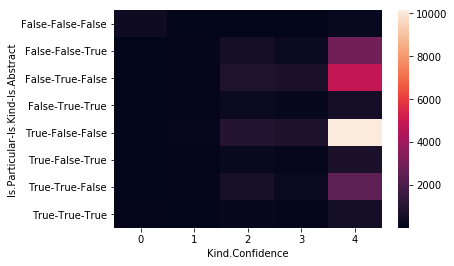

Is.Kind        False  True
Is.Particular             
False          4626   7622
True           13294  4493 

Is.Kind      False   True
Is.Abstract              
False        12786  10094
True         5134   2021  

Is.Abstract    False  True
Is.Particular             
False          7201   5047
True           15679  2108 



In [4]:
print(data.pivot_table(index=['Is.Particular', 'Is.Kind', 'Is.Abstract'], 
                       columns='Kind.Confidence', 
                       values='Annotator.ID', aggfunc=len))
print(data.pivot_table(index=['Is.Particular', 'Is.Kind', 'Is.Abstract'],  
                       values='Annotator.ID', aggfunc=len))
sns.heatmap(data.pivot_table(index=['Is.Particular', 'Is.Kind', 'Is.Abstract'], 
                             columns='Kind.Confidence', 
                             values='Annotator.ID', aggfunc=len).fillna(0))
plt.show()

print(data.pivot_table(index='Is.Particular', 
                             columns='Is.Kind',
                             values='Annotator.ID', aggfunc=len), "\n")
print(data.pivot_table(index='Is.Abstract', 
                             columns='Is.Kind',
                             values='Annotator.ID', aggfunc=len), "\n")
print(data.pivot_table(index='Is.Particular', 
                             columns='Is.Abstract',
                             values='Annotator.ID', aggfunc=len), "\n")

## Inter Annotator agreement

## Raw agreement

In [11]:
sigdig=3
def calc_raw_agreement(data, key_var, check_var):
    '''
    Input: 
    1. data: Pandas dataframe
    2. key_var: variable based on which raw agreement is to be calculated
    3. check_var: vaiable on which raw agreement is calculated
    
    '''
    print("####### Raw Count for {} ###########".format(check_var))
    ids = set(data[key_var].values.tolist())

    total_count = len(ids)
    raw_count = 0
    keys = []
    
    for iden in ids:
        temp = list(data[data[key_var] == iden][check_var].values)
        if temp.count(temp[0]) == len(temp):
            raw_count += 1
            keys.append(iden)
     
    agreement = np.round((raw_count/total_count), sigdig)
    
    print("Total count of unique {} is {}".format(key_var, total_count))
    print("Raw count of matched for {} is {}".format(check_var, raw_count))
    print("Inter-annotator agreement for {} is {}%".format(check_var, agreement))
    print("\n")
    
    return agreement, keys

part_agreement, key_part = calc_raw_agreement(data_dev, 'Unique.ID', 'Is.Particular')
kind_agreement, key_kind = calc_raw_agreement(data_dev, 'Unique.ID', 'Is.Kind')
abs_agreement, key_abs = calc_raw_agreement(data_dev, 'Unique.ID', 'Is.Abstract')

####### Raw Count for Is.Particular ###########
Total count of unique Unique.ID is 3611
Raw count of matched for Is.Particular is 1646
Inter-annotator agreement for Is.Particular is 0.456%


####### Raw Count for Is.Kind ###########
Total count of unique Unique.ID is 3611
Raw count of matched for Is.Kind is 1386
Inter-annotator agreement for Is.Kind is 0.384%


####### Raw Count for Is.Abstract ###########
Total count of unique Unique.ID is 3611
Raw count of matched for Is.Abstract is 2131
Inter-annotator agreement for Is.Abstract is 0.59%




## Average of accuracy and kappa for each pair

In [7]:
def ridit(x):
    '''apply ridit scoring

    Parameters
    ----------
    x : iterable

    Returns
    -------
    numpy.array
    '''
    x_flat = np.array(x, dtype=int).flatten()
    x_shift = x_flat - x_flat.min()     # bincount requires nonnegative ints

    bincounts = np.bincount(x_shift)
    props = bincounts / bincounts.sum()

    cumdist = np.cumsum(props)
    cumdist[-1] = 0.                    # this looks odd but is right

    ridit_map = np.array([cumdist[i - 1] + p / 2 for i, p in enumerate(props)])

    return ridit_map[x_shift]

def extract_pairs_of_workers(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def average_kappa_acc(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score
    
    Output: kappa score and average accuracy for (pairs of annotators) in the dataset

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    
    kappas = []
    corrs = []
    accuracies = []
    lens = []
    for (w1, w2) in worker_pairs:
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        temp1 = []
        temp2 = []
        
        if common_set == set():
            continue

        for key in common_set:
            val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values

            temp1.append(val1[0])
            temp2.append(val2[0])
        if not isnan(kappa(temp1, temp2)):
            kappas.append(kappa(temp1, temp2))
        else:
            kappas.append(0)
        accuracies.append(accuracy(temp1, temp2))
        lens.append(len(temp1))
        corrs.append(spearman(temp1, temp2)[0])
    return kappas, accuracies, lens, corrs


In [8]:
# ridit scoring
for attr in attributes:
    resp = attr_map[attr]
    resp_conf = attr_conf[attr]
    data_dev[resp_conf] = data_dev.groupby('Annotator.ID')[resp_conf].transform(ridit)
kappas = {}
corrs = {}
accs = {}
lens_d = {}

for var in attributes:
    kappas[var], accs[var], lens_d[var], corrs[var] = average_kappa_acc(data_dev,\
                                                                        'Annotator.ID',\
                                                                        'Unique.ID',\
                                                                        attr_map[var])

/Users/venkat/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/venkat/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/venkat/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/venkat/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/venkat/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/venkat/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:370: RuntimeWarning: invalid value e

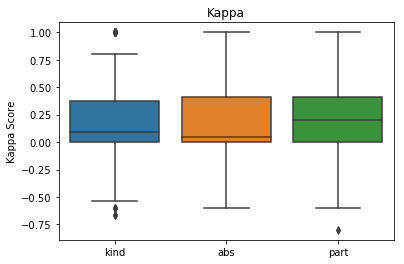

kind    0.155423
abs     0.208887
part    0.228819
dtype: float64
{'part': 0.23, 'kind': 0.154, 'abs': 0.211}


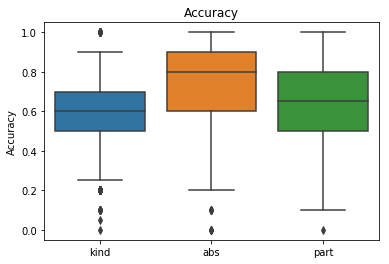

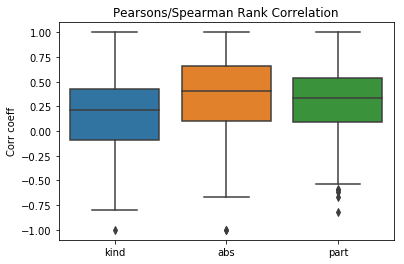

kind    0.208027
abs     0.353227
part    0.303663
dtype: float64


In [12]:
kappa_data = pd.DataFrame.from_dict(kappas)
acc_data = pd.DataFrame.from_dict(accs)
corr_data = pd.DataFrame.from_dict(corrs)

ax = sns.boxplot(data=kappa_data)
ax.set(ylabel='Kappa Score', title="Kappa")
plt.show()

kappa_mean = {'part':0, 'kind':0, 'abs':0}
for var in attributes:
    total = sum(lens_d[var])
    kappa_mean[var] = np.round(sum([kappas[var][i] * lens_d[var][i] / total for i in range(len(lens_d[var]))]), sigdig)
print(np.mean(kappa_data))
print(kappa_mean) 

ax = sns.boxplot(data=acc_data)
ax.set(ylabel='Accuracy', title="Accuracy")
plt.show()

ax = sns.boxplot(data=corr_data)
ax.set(ylabel='Corr coeff', title="Pearsons/Spearman Rank Correlation")
plt.show()
print(np.mean(corr_data))

# Predicate protocol

In [13]:
attributes = {"part", "dyn", "hyp"}
attr_map = {"part": "Is.Particular", "dyn": "Is.Dynamic", "hyp": "Is.Hypothetical"}
attr_conf = {"part": "Part.Confidence", "dyn": "Dyn.Confidence", "hyp": "Hyp.Confidence"}

data_file = "../../../data/pred_raw_data.tsv"
data = pd.read_csv(data_file, sep="\t")

data['Unique.ID'] = data.apply(lambda x: x['Split'] + " sent_" + str(x['Sentence.ID']) +\
                               "_" + str(x["Span"]), axis=1)
data_test = data[data['Split'] == "test"]
data_dev = data[data['Split'] == "dev"]
data = data[data['Split'] == "train"]
print(len(data), len(data_test), len(data_dev))

26721 9357 9822


## Count plots and heat maps of annotations

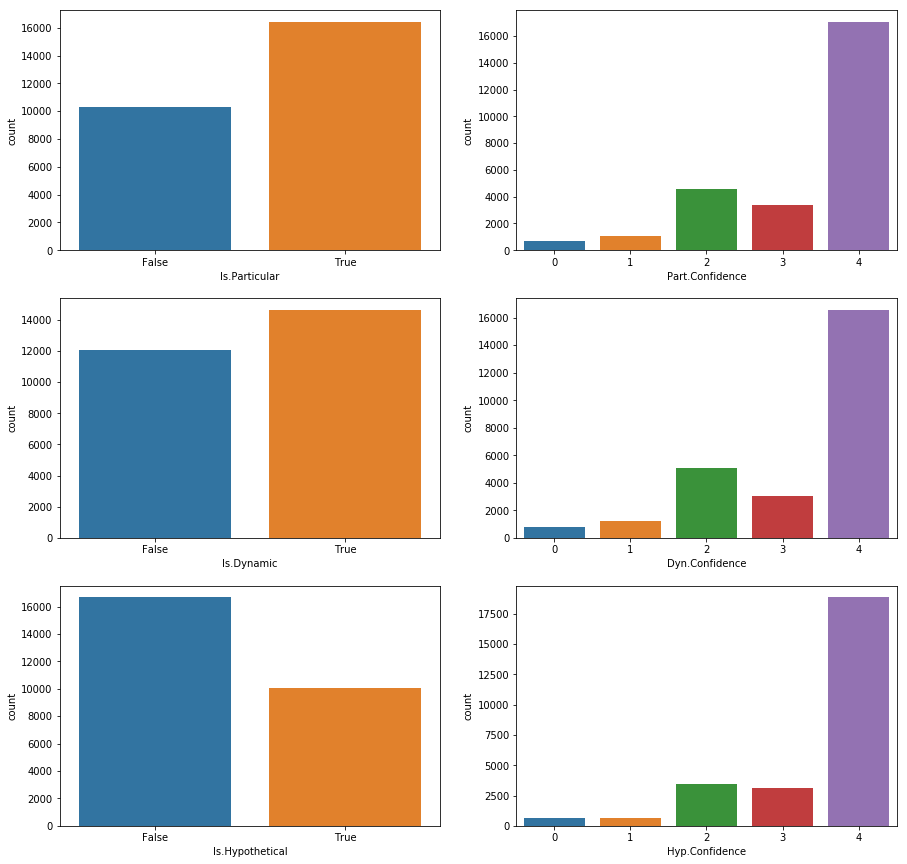

In [14]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(15, 15))
sns.countplot(x='Is.Particular', data=data, ax=axs[0][0])
sns.countplot(x='Is.Dynamic', data=data, ax=axs[1][0])
sns.countplot(x='Is.Hypothetical', data=data, ax=axs[2][0])

sns.countplot(x='Part.Confidence', data=data, ax=axs[0][1])
sns.countplot(x='Dyn.Confidence', data=data, ax=axs[1][1])
sns.countplot(x='Hyp.Confidence', data=data, ax=axs[2][1])

plt.show()

Dyn.Confidence                              0    1     2    3     4
Is.Particular Is.Dynamic Is.Hypothetical                           
False         False      False            365  81   277   147  785 
                         True             101  162  629   301  1934
              True       False            25   117  580   340  1753
                         True             55   155  557   422  1512
True          False      False            110  290  1046  415  3721
                         True             65   118  395   194  930 
              True       False            56   206  1108  855  4390
                         True             36   89   467   376  1556


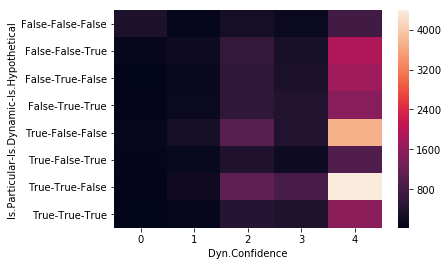

Is.Dynamic     False  True
Is.Particular             
False          4782   5516
True           7284   9139 

Is.Hypothetical  False  True
Is.Dynamic                  
False            7237   4829
True             9430   5225 

Is.Hypothetical  False  True
Is.Particular               
False            4470   5828
True             12197  4226 



In [15]:
print(data.pivot_table(index=['Is.Particular', 'Is.Dynamic', 'Is.Hypothetical'], 
                       columns='Dyn.Confidence', 
                       values='Annotator.ID', aggfunc=len))
sns.heatmap(data.pivot_table(index=['Is.Particular', 'Is.Dynamic', 'Is.Hypothetical'], 
                             columns='Dyn.Confidence', 
                             values='Annotator.ID', aggfunc=len).fillna(0))
plt.show()

print(data.pivot_table(index='Is.Particular', 
                             columns='Is.Dynamic',
                             values='Annotator.ID', aggfunc=len), "\n")
print(data.pivot_table(index='Is.Dynamic', 
                             columns='Is.Hypothetical',
                             values='Annotator.ID', aggfunc=len), "\n")
print(data.pivot_table(index='Is.Particular', 
                             columns='Is.Hypothetical',
                             values='Annotator.ID', aggfunc=len), "\n")

## Raw agreement

In [16]:
part_agreement, key_part = calc_raw_agreement(data_dev, 'Unique.ID', 'Is.Particular')
kind_agreement, key_kind = calc_raw_agreement(data_dev, 'Unique.ID', 'Is.Dynamic')
abs_agreement, key_abs = calc_raw_agreement(data_dev, 'Unique.ID', 'Is.Hypothetical')

####### Raw Count for Is.Particular ###########
Total count of unique Unique.ID is 3274
Raw count of matched for Is.Particular is 1085
Inter-annotator agreement for Is.Particular is 0.331%


####### Raw Count for Is.Dynamic ###########
Total count of unique Unique.ID is 3274
Raw count of matched for Is.Dynamic is 1024
Inter-annotator agreement for Is.Dynamic is 0.313%


####### Raw Count for Is.Hypothetical ###########
Total count of unique Unique.ID is 3274
Raw count of matched for Is.Hypothetical is 1320
Inter-annotator agreement for Is.Hypothetical is 0.403%




## Kappa

In [17]:
# ridit scoring
for attr in attributes:
    resp = attr_map[attr]
    resp_conf = attr_conf[attr]
    data_dev[resp_conf] = data_dev.groupby('Annotator.ID')[resp_conf].transform(ridit)
kappas = {}
corrs = {}
accs = {}
lens_d = {}

for var in attributes:
    kappas[var], accs[var], lens_d[var], corrs[var] = average_kappa_acc(data_dev,\
                                                                        'Annotator.ID',\
                                                                        'Unique.ID',\
                                                                        attr_map[var])

/Users/venkat/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/venkat/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/venkat/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/venkat/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/venkat/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/venkat/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:370: RuntimeWarning: invalid value e

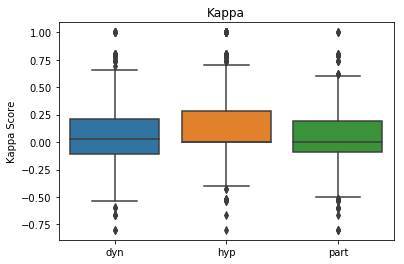

dyn     0.073060
hyp     0.117554
part    0.043504
dtype: float64
{'part': 0.043, 'hyp': 0.112, 'dyn': 0.072}


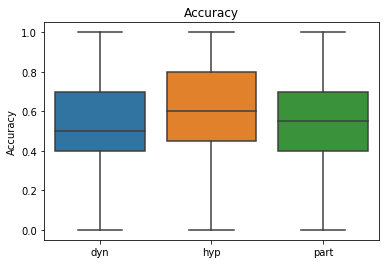

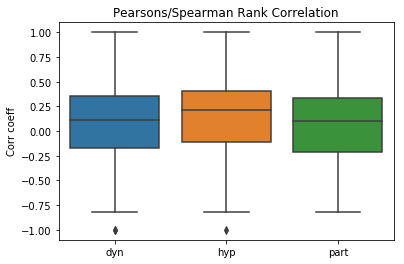

dyn     0.099076
hyp     0.189515
part    0.071954
dtype: float64


In [19]:
kappa_data = pd.DataFrame.from_dict(kappas)
acc_data = pd.DataFrame.from_dict(accs)
corr_data = pd.DataFrame.from_dict(corrs)

ax = sns.boxplot(data=kappa_data)
ax.set(ylabel='Kappa Score', title="Kappa")
plt.show()

kappa_mean = {'part':0, 'hyp':0, 'dyn':0}
for var in attributes:
    total = sum(lens_d[var])
    kappa_mean[var] = np.round(sum([kappas[var][i] * lens_d[var][i] / total for i in range(len(lens_d[var]))]), sigdig)
print(np.mean(kappa_data))
print(kappa_mean) 

ax = sns.boxplot(data=acc_data)
ax.set(ylabel='Accuracy', title="Accuracy")
plt.show()

ax = sns.boxplot(data=corr_data)
ax.set(ylabel='Corr coeff', title="Pearsons/Spearman Rank Correlation")
plt.show()
print(np.mean(corr_data))

In [ ]:
def extract_pairs_of_workers(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is 
    set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def ridit_dataframe(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score
    
    Output: kappa score and average accuracy for (pairs of annotators) in the dataset

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    
    cols = ['hit_id','sent_noun','worker1_id','worker2_id','agreement']
    ridit_df = pd.DataFrame(columns=cols)
    kappas = []
    accuracies = []
    for (w1, w2) in worker_pairs:
        
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        
        if common_set == set():
            continue

        for key in common_set:
            val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values[0]
            val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values[0]
            val3 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)]['hit_id'].values[0]
            agreement = (val1 == val2)
            temp_row = {'hit_id': val3, 'sent_noun': key, 'worker1_id': w1, 
                        'worker2_id': w2, 'agreement': agreement}
            ridit_df.append(temp_row, ignore_index=True)
            reversed_temp_row = {'hit_id': val3, 'sent_noun': key, 'worker1_id': w2, 
                                 'worker2_id': w1, 'agreement': agreement}
            ridit_df.append(reversed_temp_row, ignore_index=True)
        
    return ridit_df



In [ ]:
# The flipping happens here
# ridit_df = ridit_dataframe(data,'worker_id','sent_noun','part')
# ridit_df.head()

In [22]:
# Enables the %%R magic 
%load_ext rpy2.ipython
%R require(ggplot2); require(tidyr); require(lme4)

/Users/venkat/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: ggplot2

  warnings.warn(x, RRuntimeWarning)
/Users/venkat/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Error: package or namespace load failed for ‘ggplot2’ in dyn.load(file, DLLpath = DLLpath, ...):
 unable to load shared object '/Users/venkat/Library/R/3.5/library/Rcpp/libs/Rcpp.so':
  dlopen(/Users/venkat/Library/R/3.5/library/Rcpp/libs/Rcpp.so, 6): Library not loaded: /opt/local/Library/Frameworks/R.framework/Versions/3.5/Resources/lib/libR.dylib
  Referenced from: /Users/venkat/Library/R/3.5/library/Rcpp/libs/Rcpp.so
  Reason: image not found

  warnings.warn(x, RRuntimeWarning)
/Users/venkat/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: tidyr

  warnings.warn(x, RRuntimeWarning)
/Users/venkat/anaconda3/lib/python3.6/site-packages/rpy2/rinterfac

array([0], dtype=int32)

# Run Mixed effects model in R

## Part

In [ ]:
%%R -i data_dev -o df_part

#Convert to factors
data$part = as.factor(data$part)
data$kind = as.factor(data$kind)
data$abs = as.factor(data$abs)

#Mixed Effects Model
model = glmer(part ~ 1 + (1|worker_id) + (1|sent_noun) + (1|hit_id), data=data,  family=binomial)

#Model intercepts:
df_part = ranef(model)$worker_id
colnames(df_part) <- c('intercept')

df_part$glmer_intercept_part = df_part$intercept + 0.71698 #constant added manually
df_part$worker_id <- rownames(df_part)
print(summary(model))

/Users/venkat/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [24]:
df_part['glmer_intercept_part'] = df_part['glmer_intercept_part'].apply(lambda x: 1/(1+np.exp(-x)))

NameError: name 'df_part' is not defined

In [ ]:
df_part.glmer_intercept_part.plot(kind='density')
plt.title("Annotator probability density of saying part = true")
plt.show()

## Kind

In [ ]:
%%R -i data -o df_kind

#Convert to factors
data$part = as.factor(data$part)
data$kind = as.factor(data$kind)
data$abs = as.factor(data$abs)

#Mixed Effects Model
model = glmer(kind ~ 1 + (1|worker_id) + (1|sent_noun) + (1|hit_id), data=data,  family="binomial")

#Model intercepts:
df_kind = ranef(model)$worker_id
colnames(df_kind) <- c('intercept')

df_kind$glmer_intercept_kind = df_kind$intercept - 0.115 #constant added manually
df_kind$worker_id <- rownames(df_kind)

print(summary(model))

In [ ]:
df_kind['glmer_intercept_kind'] = df_kind['glmer_intercept_kind'].apply(lambda x: 1/(1+np.exp(-x)))

In [ ]:
df_kind.glmer_intercept_kind.plot(kind='density')
plt.title("Annotator probability density of saying kind = true")
plt.show()

## Abs

In [ ]:
%%R -i data -o df_abs

#Convert to factors
data$part = as.factor(data$part)
data$kind = as.factor(data$kind)
data$abs = as.factor(data$abs)

#Mixed Effects Model
model = glmer(abs ~ 1 + (1|worker_id) + (1|sent_noun) + (1|hit_id), data=data,  family="binomial")

#Model intercepts:
df_abs = ranef(model)$worker_id
colnames(df_abs) <- c('intercept')

df_abs$glmer_intercept_abs = df_abs$intercept - 1.778 #constant added manually
df_abs$worker_id <- rownames(df_abs)

print(summary(model))

In [ ]:
df_abs['glmer_intercept_abs'] = df_abs['glmer_intercept_abs'].apply(lambda x: 1/(1+np.exp(-x)))

In [ ]:
df_abs.glmer_intercept_abs.plot(kind='density')
plt.title("Annotator probability density of saying abstract = true")
plt.show()

In [ ]:
def extract_pairs_of_workers(data, worker_id):
    '''
    Given a pandas dataframe, and worker_id variable,
    extracts a list of pairs of worker_ids
    '''
    workers = list(set(data[worker_id].values))
    
    return list(itertools.combinations(workers, 2))

def extract_worker_sent_dict(data, worker_id, sent_id):
    '''
    Given a pandas dataframe, worker_id variable, and sentence_id variable,
    extracts a dict where key is worker_id and value is set(sentences_ids annotated by that worker)
    
    '''
    workers = list(set(data[worker_id].values))
    
    ans = {}
    
    for worker in workers:
        sents = set(list(data[data[worker_id] == worker][sent_id].values))
        ans[worker] = sents
        
    return ans

def average_kappa_acc(data, worker_id, key_var, check_var):
    '''
    Input: 1. data: pandas dataframe
           2. worker_id: Annotator id variable
           3. key_var: level of the data (sentence-predicate id)
           4. check_var: variable to be checked for kappa score
    
    Output: kappa score and average accuracy for (pairs of annotators) in the dataset

    '''
    worker_pairs = extract_pairs_of_workers(data, worker_id)
    
    worker_key_dict = extract_worker_sent_dict(data, worker_id, key_var)
    if check_var == "part":
        df = df_part
        int_prob = "glmer_intercept_part"
    elif check_var == "abs":
        df = df_abs
        int_prob = "glmer_intercept_abs"
    else:
        df = df_kind
        int_prob = "glmer_intercept_kind"

    kappas = []
    accuracies = []
    for (w1, w2) in worker_pairs:
        
        common_set = worker_key_dict[w1].intersection(worker_key_dict[w2])
        temp1 = []
        temp2 = []
        
        if common_set == set():
            continue

        for key in common_set:
            val1 = data[(data[key_var] == key) & 
                        (data[worker_id] == w1)][check_var].values
            val2 = data[(data[key_var] == key) & 
                        (data[worker_id] == w2)][check_var].values

            temp1.append(val1[0])
            temp2.append(val2[0])
        accuracies.append(accuracy(temp1, temp2))
        # Now for modified kappa calculation
        p_e = (df[df[worker_id] == w1][int_prob][0] * df[df[worker_id] == w2][int_prob][0]) + ((1 - df[df[worker_id] == w1][int_prob][0]) * (1 - df[df[worker_id] == w2][int_prob][0]))
        kappas.append((accuracies[-1] - p_e) / (1 - p_e))
        
    return kappas, accuracies

In [ ]:
kappas = {}
corrs = {}
accs = {}
variables = ['part', 'kind', 'abs']
# variables_ord = ['part_conf', 'kind_conf', 'abs_conf']
for var in variables:
    kappas[var], accs[var] = average_kappa_acc(data, 'worker_id', 'sent_noun', var)
# for var in variables_ord:
#     corrs[var], accs[var] = rank_correlation(data, 'worker_id', 'sent_noun', var)

In [ ]:
kappa_data = pd.DataFrame.from_dict(kappas)
acc_data = pd.DataFrame.from_dict(accs)
corr_data = pd.DataFrame.from_dict(corrs)

ax = sns.boxplot(data=kappa_data)
ax.set(ylabel='Kappa Score', title="Kappa")
plt.show()
print(np.mean(kappa_data))

ax = sns.boxplot(data=acc_data)
ax.set(ylabel='Accuracy', title="Accuracy")
plt.show()
print(np.mean(acc_data))